In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import modelbase
from tqdm.notebook import tqdm
from modelbase.ode import Simulator
from scipy.optimize import minimize

plt.style.use("./notebook.mplstyle")
print(modelbase.__version__)

1.3.5


In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
%%capture
cd analyses/

In [5]:
def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])


def pfd_scan(s, pfd_values, y0_loop):
    fluxes = {}
    concentrations = {}
    for i, x in tqdm(enumerate(pfd_values), total=len(pfd_values)):
        s.initialise(y0_loop)
        s.update_parameter("pfd", x)
        try:
            t, y = s.simulate(T_END)
            concentrations[x] = dict(s.get_full_results_df().iloc[-1])
            fluxes[x] = dict(s.get_fluxes_df().iloc[-1])
            # Model is sensitive to initial conditions, so set the last ones every loop
            y0_loop = get_new_y0(s)
        except:
            all_compounds = s.model.get_all_compounds()
            rate_names = s.model.get_rate_names()
            concentrations[x] = dict(
                zip(all_compounds), np.full(len(all_compounds), np.nan)
            )
            fluxes[x] = dict(zip(rate_names, np.full(len(rate_names), np.nan)))
    return pd.DataFrame(concentrations).T, pd.DataFrame(fluxes).T


NUM_SCANS = 50
T_END = 100000
LOW_LIGHT = 50
HIGH_LIGHT = 1500
PFD_VALUES = np.linspace(LOW_LIGHT, HIGH_LIGHT, NUM_SCANS)

y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [6]:
def make_PPFD_PETC_ss_fig(flux_petc_mehler, conc_petc_mehler):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    flux_petc_mehler["vPS1"].plot(ax=ax1, label="rate through PS1")
    (np.array([2])*flux_petc_mehler["vPS2"]).plot(ax=ax1, label="LEF")
    (np.array([2])*flux_petc_mehler["vCyc"]).plot(ax=ax1, label="CEF")
    ax1.set(xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)", ylabel="mmol e$^-$/mol Chl/s")
    ax1.legend(loc="upper left", borderaxespad=0.5)

    ax2.plot(flux_petc_mehler["vMehler"], 'r--', label="Mehler")
    ax2.plot(flux_petc_mehler["vPTOX"], 'r.', label="PTOX")
    ax2.set_xlabel("PPFD")
    ax2.set_ylabel("mmol e$^-$/mol Chl/s", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc="lower right", borderaxespad=0.5)

    ax1.set_title("photosynthetic electron fluxes")

    return fig, ax1, ax2
#plt.show()

In [7]:
def make_PPFD_redox_ss_fig(flux_petc_mehler, conc_petc_mehler):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    #(conc_petc_mehler["PQ"]/get_model().get_parameter('PQtot')).plot(ax=ax1, label="ox. quinons")
    #(conc_petc_mehler["PC"]/get_model().get_parameter('PCtot')).plot(ax=ax1, label="ox. cyanins")
    #(conc_petc_mehler["Fd"]/get_model().get_parameter('Fdtot')).plot(ax=ax1, label="ox. ferrodoxins")
    (conc_petc_mehler["ATP_norm"]).plot(ax=ax1, label="ATP")
    (conc_petc_mehler["NADP_redoxstate"]).plot(ax=ax1, label="NADPH")
    (conc_petc_mehler["Fd_redoxstate"]).plot(ax=ax1, label="reduced Fd")
    (conc_petc_mehler["PQ_redoxstate"]).plot(ax=ax1, label="reduced PQ")
    (conc_petc_mehler["PC_redoxstate"]).plot(ax=ax1, label="reduced PC")
    #ax1.set(xlabel="PPFD", ylabel="Oxidised fraction of the pool")
    ax1.set(xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)", ylabel="Fraction of the pool")
    #ax1.legend(title='Electron carriers', loc="upper left", borderaxespad=0.25)
    ax1.legend(loc="upper left", borderaxespad=0.25)

    ax2.plot(conc_petc_mehler["H2O2"], 'r--', label="H$_2$O$_2$")
    #ax2.plot(flux_petc_mehler["vPTOX"], 'r.', label="PTOX")
    ax2.set_xlabel("PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)")
    ax2.set_ylabel("Concentration/mM", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc="lower right", borderaxespad=0.5)

    ax1.set_title("energy and redox status")

    return fig, ax1, ax2

In [8]:
m = get_model()
par_orig = m.get_parameters()

In [9]:
s = Simulator(get_model())
s.update_parameters({"pfd": 40.0})
conc_petc_mehler, flux_petc_mehler = pfd_scan(
    s, pfd_values=PFD_VALUES, y0_loop=y0
)

  0%|          | 0/50 [00:00<?, ?it/s]

## Figure 1 A

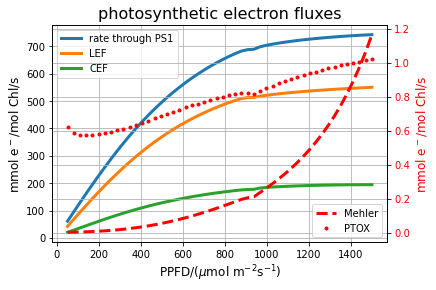

In [10]:
fig, ax1, ax2 = make_PPFD_PETC_ss_fig(flux_petc_mehler, conc_petc_mehler)

## Figure 1 B

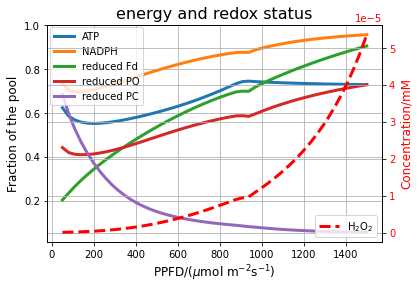

In [11]:
fig, ax1, ax2 = make_PPFD_redox_ss_fig(flux_petc_mehler,conc_petc_mehler)

### supplementary information: H2O2 from Mehler is scavenged by Ascorbate cycle, all enzymatically (MDA reductase)

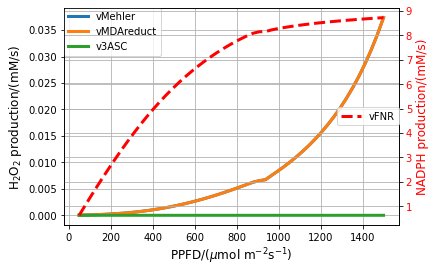

In [12]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
(flux_petc_mehler.loc[:,["vMehler","vMDAreduct","v3ASC"]]*np.array([par_orig["convf"],1,1])).plot(ax=ax1)
ax1.set_xlabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)")
ax1.set_ylabel("H$_2$O$_2$ production/(mM/s)")
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel("NADPH production/(mM/s)", color="red")
(flux_petc_mehler["vFNR"]*par_orig["convf"]).plot(ax=ax2, color="red", style="--")
ax2.legend(loc="center right")

### conentration of MDA radical is very low

Text(0, 0.5, 'Concentration/mM')

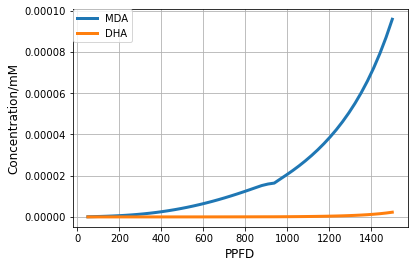

In [13]:
fig, ax = plt.subplots()
conc_petc_mehler.loc[:,["MDA","DHA"]].plot(ax=ax)
ax.set_xlabel("PPFD")
ax.set_ylabel("Concentration/mM")

## More steady-state analyses

#### The quencher and it's components

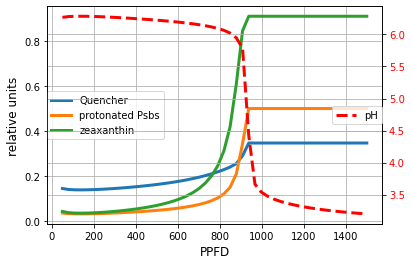

In [14]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("PPFD")
ax2 = ax1.twinx()
conc_petc_mehler["Q"].plot(ax=ax1, label="Quencher")
#conc_petc_mehler["LHCp"].plot(ax=ax1, label="protonated LHC")
conc_petc_mehler["Psbsp"].plot(ax=ax1, label="protonated Psbs")
conc_petc_mehler["Zx"].plot(ax=ax1, label="zeaxanthin")
q0=pd.DataFrame(
    {
        "q0":m.get_parameter("gamma0")*np.array(conc_petc_mehler["Vx"])*np.array(conc_petc_mehler["Psbs"]),
        "q1":m.get_parameter("gamma1")*np.array(conc_petc_mehler["Vx"])*np.array(conc_petc_mehler["Psbsp"]),
#        "q2":m.get_parameter("gamma2")*np.array(conc_petc_mehler["Vx"])*np.array(conc_petc_mehler["Psbs"]),
#        "q3":m.get_parameter("gamma3")*np.array(conc_petc_mehler["Vx"])*np.array(conc_petc_mehler["Psbs"]),
    },
    index=conc_petc_mehler.index)
#q0["q0"].plot(ax=ax1,label="$q_0$")
#q0["q1"].plot(ax=ax1,label="$q_1$")
ax1.legend(loc="center left")
ax1.set_ylabel("relative units")

conc_petc_mehler["pH"].plot(ax=ax2, color="red", style="--", label="pH")
#ax2.set_ylabel(color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc="right")

#### energy status (ATP/(ADP+ATP) and NADPH/(NADP+NADPH))

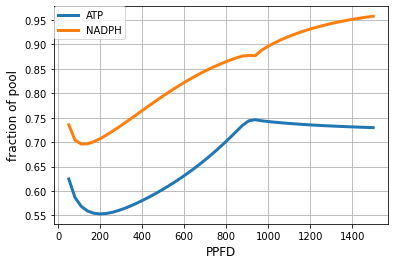

In [15]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("PPFD")
conc_petc_mehler["ATP_norm"].plot(ax=ax1, label="ATP")
conc_petc_mehler["NADP_redoxstate"].plot(ax=ax1, label="NADPH")
ax1.set_ylabel("fraction of pool")
ax1.legend()

#### some CBB cycle intermediates

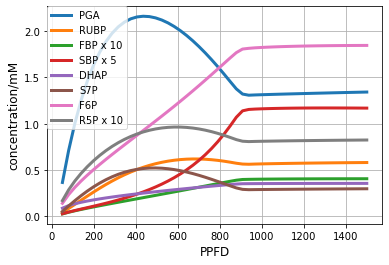

In [16]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("PPFD")
conc_petc_mehler["PGA"].plot(ax=ax1, label="PGA")
conc_petc_mehler["RUBP"].plot(ax=ax1, label="RUBP")
(conc_petc_mehler["FBP"]*np.array([10])).plot(ax=ax1, label="FBP x 10")
(conc_petc_mehler["SBP"]*np.array([5])).plot(ax=ax1, label="SBP x 5")
conc_petc_mehler["DHAP"].plot(ax=ax1, label="DHAP")
conc_petc_mehler["S7P"].plot(ax=ax1, label="S7P")
conc_petc_mehler["F6P"].plot(ax=ax1, label="F6P")
(conc_petc_mehler["R5P"]*np.array([10])).plot(ax=ax1, label="R5P x 10")

ax1.set_ylabel("concentration/mM")
ax1.legend()

#### some CBB cycle fluxes

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("PPFD")
flux_petc_mehler["vRuBisCO"].plot(ax=ax1, label="CO$_2$ fixation")
(flux_petc_mehler["vStarch"]*np.array([6])).plot(ax=ax1, label="starch")
(flux_petc_mehler["vgap"]*np.array([3])).plot(ax=ax1, label="GAP export")
(flux_petc_mehler["vdhap"]*np.array([3])).plot(ax=ax1, label="DHAP export")
(flux_petc_mehler["vpga"]*np.array([3])).plot(ax=ax1, label="PGA export")
triose_tot=(flux_petc_mehler.loc[:,["vgap","vdhap","vpga"]]*np.array([3,3,3])).sum(1)
(triose_tot).plot(ax=ax1, style="--", color="black", label="total triose export")
ax1.set_ylabel("flux/(C-mM/s)")
ax1.legend()

#### ATP/NADPH production and consumption ratios

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)")
atpnadphproductionratio = pd.DataFrame(
    {
        "ATP/NADPH":np.array(flux_petc_mehler["vATPsynthase"])/np.array(flux_petc_mehler["vFNR"]),
    }, index=flux_petc_mehler.index
)
atpnadphproductionratio["ATP/NADPH"].plot(ax=ax1,label="production")
atpnadphconsumptionratio = pd.DataFrame(
    {
        "ATP/NADPH":(np.array(flux_petc_mehler["vPGA_kinase"]) +
                     np.array(flux_petc_mehler["v13"]) +
                     np.array(flux_petc_mehler["vStarch"]))/np.array(flux_petc_mehler["vBPGA_dehydrogenase"]),
    }, index=flux_petc_mehler.index
)
atpnadphconsumptionratio["ATP/NADPH"].plot(ax=ax1,label="consumption in TCA cycle")
ax1.set_ylabel("ATP/NADPH flux ratio")
ax1.legend(loc="upper right")

In [ ]:
m.stoichiometries_by_compounds["ATP"]

In [ ]:
m.stoichiometries_by_compounds["NADPH"]

In [ ]:
m.stoichiometries_by_compounds["BPGA"]

In [ ]:
flux_petc_mehler.loc[:,["vBPGA_dehydrogenase","vPGA_kinase"]].plot()

## Analysis of an MDA reductase knockdown (1% of enzyme)

In [14]:
m.update_parameters({"MDAR0": par_orig["MDAR0"]/100})
s = Simulator(m)
s.update_parameters({"pfd": 40.0})
conc_petc_mehler_asckd, flux_petc_mehler_asckd = pfd_scan(
    s, pfd_values=PFD_VALUES, y0_loop=y0
)
m.update_parameters({"MDAR0": par_orig["MDAR0"]})

  0%|          | 0/50 [00:00<?, ?it/s]

Fluxes and concentrations are the same ...

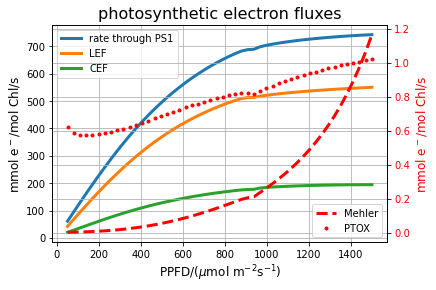

In [17]:
fig, ax1, ax2 = make_PPFD_PETC_ss_fig(flux_petc_mehler_asckd, conc_petc_mehler_asckd)

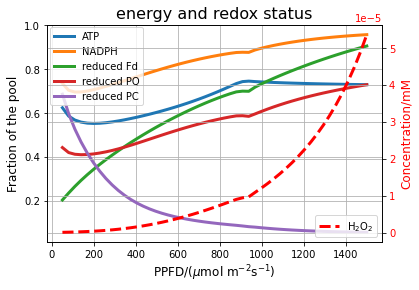

In [18]:
fig, ax1, ax2 = make_PPFD_redox_ss_fig(flux_petc_mehler_asckd, conc_petc_mehler_asckd)

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

flux_petc_mehler["vPS1"].plot(ax=ax1, label="rate through PS1")
(np.array([2])*flux_petc_mehler_asckd["vPS2"]).plot(ax=ax1, label="LEF")
(np.array([2])*flux_petc_mehler_asckd["vCyc"]).plot(ax=ax1, label="CEF")
#(np.array([2])*flux_petc_mehler_asckd["vNDH"]).plot(ax=ax1, label="NDH")
ax1.set(xlabel="PPFD", ylabel="Flux/e$^-$ mmol/mol Chl/s")
ax1.legend(loc="upper left", borderaxespad=0.5)

ax2.plot(flux_petc_mehler_asckd["vMehler"], 'r--', label="Mehler")
ax2.plot(flux_petc_mehler_asckd["vPTOX"], 'r.', label="PTOX")
ax2.set_xlabel("PPFD")
ax2.set_ylabel("Flux [mM/s]", color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc="lower right", borderaxespad=0.5)

plt.show()

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#fig.align_labels()

#(conc_petc_mehler_asckd["PQ"]/get_model().get_parameter('PQtot')).plot(ax=ax1, label="ox. quinons")
#(conc_petc_mehler_asckd["PC"]/get_model().get_parameter('PCtot')).plot(ax=ax1, label="ox. cyanins")
#(conc_petc_mehler_asckd["Fd"]/get_model().get_parameter('Fdtot')).plot(ax=ax1, label="ox. ferrodoxins")
(conc_petc_mehler_asckd["PQ_redoxstate"]).plot(ax=ax1, label="reduced PQ")
(conc_petc_mehler_asckd["PC_redoxstate"]).plot(ax=ax1, label="reduced PC")
(conc_petc_mehler_asckd["Fd_redoxstate"]).plot(ax=ax1, label="reduced Fd")
ax1.set(xlabel="PPFD", ylabel="Reduced fractions of pools")
ax1.legend(title='Electron carriers', loc="upper left", borderaxespad=0.25)

ax2.plot(conc_petc_mehler_asckd["H2O2"], 'r--', label="H$_2$O$_2$")
#ax2.plot(flux_petc_mehler["vPTOX"], 'r.', label="PTOX")
ax2.set_xlabel("PPFD")
ax2.set_ylabel("Concentration/mM", color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc="center right", borderaxespad=0.5)
fig.align_ylabels([ax1,ax2])

plt.show()

... but now the spontaneous reaction (MDA disproportionation) becomes more important ...

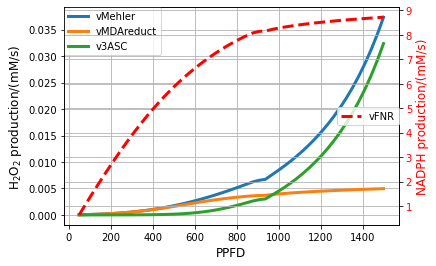

In [19]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
(flux_petc_mehler_asckd.loc[:,["vMehler","vMDAreduct","v3ASC"]]*np.array([par_orig["convf"],1,1])).plot(ax=ax1)
ax1.set_xlabel("PPFD")
ax1.set_ylabel("H$_2$O$_2$ production/(mM/s)")
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel("NADPH production/(mM/s)", color="red")
(flux_petc_mehler_asckd["vFNR"]*par_orig["convf"]).plot(ax=ax2, color="red", style="--")
ax2.legend(loc="center right")
#(flux_petc_mehler_asckd.loc[:,["vMehler","vMDAreduct","v3ASC"]]*np.array([par_orig["convf"],1,1])).plot()

... and the concentration of the radical MDA is vastly increased over the mutant (see scale)

Text(0, 0.5, 'Concentration/mM')

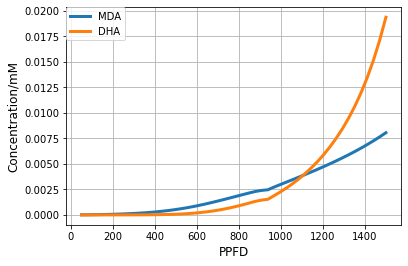

In [20]:
fig, ax = plt.subplots()
conc_petc_mehler_asckd.loc[:,["MDA","DHA"]].plot(ax=ax)
ax.set_xlabel("PPFD")
ax.set_ylabel("Concentration/mM")

## Analysis of a PGR5 knockdown (1% of enzyme)

In [23]:
m.update_parameters({"kcyc": par_orig["kcyc"]/100})
s = Simulator(m)
s.update_parameters({"pfd": 40.0})
conc_petc_mehler_cyckd, flux_petc_mehler_cyckd = pfd_scan(
    s, pfd_values=PFD_VALUES, y0_loop=y0
)
m.update_parameters({"kcyc": par_orig["kcyc"]})

  0%|          | 0/50 [00:00<?, ?it/s]

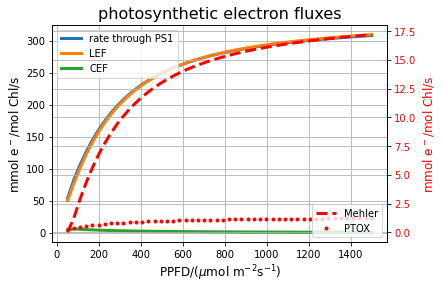

In [25]:
fig, ax1, ax2 = make_PPFD_PETC_ss_fig(flux_petc_mehler_cyckd, conc_petc_mehler_cyckd)

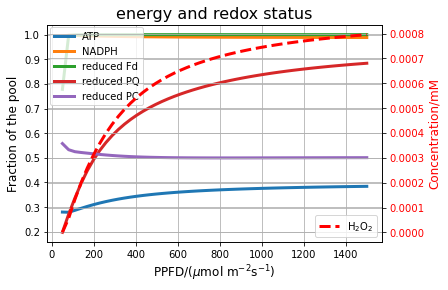

In [26]:
fig, ax1, ax2 = make_PPFD_redox_ss_fig(flux_petc_mehler_cyckd, conc_petc_mehler_cyckd)

... but now the spontaneous reaction (MDA disproportionation) becomes more important ...

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
(flux_petc_mehler_asckd.loc[:,["vMehler","vMDAreduct","v3ASC"]]*np.array([par_orig["convf"],1,1])).plot(ax=ax1)
ax1.set_xlabel("PPFD")
ax1.set_ylabel("H$_2$O$_2$ production/(mM/s)")
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel("NADPH production/(mM/s)", color="red")
(flux_petc_mehler_asckd["vFNR"]*par_orig["convf"]).plot(ax=ax2, color="red", style="--")
ax2.legend(loc="center right")
#(flux_petc_mehler_asckd.loc[:,["vMehler","vMDAreduct","v3ASC"]]*np.array([par_orig["convf"],1,1])).plot()

... and the concentration of the radical MDA is vastly increased over the mutant (see scale)

In [ ]:
fig, ax = plt.subplots()
conc_petc_mehler_asckd.loc[:,["MDA","DHA"]].plot(ax=ax)
ax.set_xlabel("PPFD")
ax.set_ylabel("Concentration/mM")

## Comparison to relative maximal quantities

In [ ]:
def relative_to_max(df, names, max_=None):
    if max_ is None:
        return df.loc[:, names] * 100 / df.loc[:, names].max()
    else:
        return df.loc[:, names] * 100 / max_

In [ ]:
# rates: "vMehler", vDeepox", "vEpox", "vLhcdeprotonation", vLhcprotonation"
# concentrations : "Fluo", "Q"

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
ax1, ax2, ax3, ax4 = axs.ravel()

flux_petc_mehler["vMehler"].plot(ax=ax1, label="Mehler reaction")
flux_petc_mehler["vPTOX"].plot(ax=ax1, label="Fluorescence")
flux_petc_mehler["vPS1"].plot(ax=ax1, label="Quencher")
flux_petc_mehler["vPS2"].plot(ax=ax1, label="LEF")
flux_petc_mehler["vCyc"].plot(ax=ax1, label="CEF")
#compensation_point = flux_petc_mehler["vMehler"].diff().diff().idxmax()
# ax.axvline(compensation_point, color=(0, 0, 0, 1 / 6), linestyle="dashed")
# ax.axvspan(compensation_point - 25, compensation_point + 25, color=(0, 0, 0, 1 / 16))
ax1.set(
    xlabel="PFD",
    ylabel="flux or concentration, both [%]",
    #     title=f"Compensation point ≈ {compensation_point:.0f} PFD",
)

conc_petc_mehler.loc[:, ["ATP", "NADPH"]].plot(ax=ax2)
conc_petc_mehler.loc[:, ["H2O2"]].plot(ax=ax3)
conc_petc_mehler.loc[:, ["pH"]].plot(ax=ax4)
# flux_petc_mehler.loc[:,  ["v9"]].plot(ax=ax4)

for ax in axs.ravel():
    ax.legend(bbox_to_anchor=(1.01, 1))
fig.tight_layout()
plt.show()